In [4]:
import numpy as np
import scipy as sp
import scipy.io as sio
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt

In [5]:
# read the txt file for the homogeneous 2D coordinates in both images
# filename is the directory to the txt file, first line number of points rest coordinates of pts
def get_data_from_txt_file_mine(filename):
    with open(filename) as f:
        lines = f.read().split()
    num_pts = int(lines[0])
    nonhomogeneous_points = np.array([float(l) for l in lines[1:]]).reshape(-1,2)
    points = np.pad(nonhomogeneous_points[:,::-1], [(0,0),(0,1)], constant_values=1.)
    return points

In [6]:
"While reading the 2D points, first element treated as y, second as x"
def get_data_from_txt_file(filename, use_subset = False):
    with open(filename) as f:
            lines = f.read().splitlines()
    number_pts = int(lines[0])

    points = np.ones((number_pts, 3))
    for i in range(number_pts):
        split_arr = lines[i+1].split()
        if len(split_arr) == 2:
            y, x = split_arr
        else:
            x, y, z = split_arr
            points[i,2] = z
        points[i,0] = x 
        points[i,1] = y
    return points

### 1. Fundamental Matrix Estimation From Point Correspondences

In [7]:
"""
General framework for determining Fundamental matrix with 8 point algorithms
1. Get 8 corresponding points' 2D homogeneous coordinate on both images
2. reformulate the constraint to treat F as a unknown vector f in linear system
3. use SVD to obtain least square unit norm solution for f
4. reconstruct F from f, construct best rank-2 approximation of F as solution
5. best rank-2 approximation of F is done through SVD
"""
data_dir = '/Users/yuf/Desktop/class material/CS231a-3Drecon/Assignment/P2/ps2/data'
im_set = data_dir + '/set1'
im_set1 = data_dir + '/set2'
im_subset = data_dir + '/set1_subset'
statue = data_dir + '/statue'

#### (a) standard 8-point algorithms for determining Fundamental matrix

In [8]:
def lls_8points_fundamental(points1,points2):
    # reformulate the constraint to treat F as f and obtain linear system W @ f = 0
    "here is the major difference: the way we compute W"
    W = np.repeat(points1,3,axis=1) * np.tile(points2,(1,3))
    #W = np.repeat(points2,3,axis=1) * np.tile(points1,(1,3))
    # use SVD to obtain least square unit norm solution for f
    u,sig,vt = np.linalg.svd(W)
    f = vt[-1]
    # reconstruct F from f, construct best rank-2 approximation of F as solution
    F_hat = f.reshape(3,3)
    u,sig,vt = np.linalg.svd(F_hat)
    sig[-1] = 0.0
    F = sig  * u @ vt
    return F
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
F = lls_8points_fundamental(points1,points2)
print('For Dataset1, Standard 8-point algorithm obtain F as\n',F,'\n')

points1 = get_data_from_txt_file(im_set1+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set1+'/pt_2D_2.txt')
F = lls_8points_fundamental(points1,points2)
print('For Dataset2, Standard 8-point algorithm obtain F as\n',F)

For Dataset1, Standard 8-point algorithm obtain F as
 [[ 1.55218081e-06 -5.86997052e-06 -3.52312036e-03]
 [-8.18161523e-06 -3.02892219e-07  1.41453881e-02]
 [-1.50440111e-03 -1.13607605e-02  9.99828068e-01]] 

For Dataset2, Standard 8-point algorithm obtain F as
 [[-5.63087200e-06 -2.77622828e-05  1.07623595e-02]
 [ 2.74976583e-05 -6.74748522e-06 -1.22519240e-02]
 [-6.42650411e-03  1.52182033e-02 -9.99730547e-01]]


#### (b) normalized 8-point algorithms to determine Fundamental matrix

In [9]:
def normalized_eight_point_fundamental(points1, points2):
    # 1. obtain center value
    center1 = np.mean(points1[:,:2],axis=0)
    pts1 = points1[:,:2]-center1
    center2 = np.mean(points2[:,:2],axis=0)
    pts2 = points2[:,:2]-center2
    # 2. re-scale factor
    factor1 = np.sqrt(2/np.mean(np.sum(pts1**2,axis=1)))
    factor2 = np.sqrt(2/np.mean(np.sum(pts2**2,axis=1)))
    # 3. construct transition matrix T
    T1 = np.array([[factor1, 0., -center1[0]*factor1],
                   [0., factor1, -center1[1]*factor1],
                   [0.,       0.,                 1.]])
    T2 = np.array([[factor2, 0., -center2[0]*factor2],
                   [0., factor2, -center2[1]*factor2],
                   [0.,       0.,                 1.]])
    # 4. convert to P2 coordinate
    pts1 = (T1@(points1.T)).T
    pts2 = (T2@(points2.T)).T
    # 5. Apply standard lls 8-pts algorithm to determine Fundamental matrix
    Fq = lls_8points_fundamental(pts1,pts2)
    # 6. re_normalize on Fq to obtain F
    "Note that this expression has TYPO in lecture note"
    F = T1.T @ Fq @ T2
    return F

# Data-set 1
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
F = normalized_eight_point_fundamental(points1,points2)
print('For Dataset1, Normalized 8-point algorithm obtain F as\n',F,'\n')

# Data-set 2
points1 = get_data_from_txt_file(im_set1+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set1+'/pt_2D_2.txt')
F = normalized_eight_point_fundamental(points1,points2)
print('For Dataset2, Normalized 8-point algorithm obtain F as\n',F)

For Dataset1, Normalized 8-point algorithm obtain F as
 [[ 6.52113484e-07 -4.91237449e-06 -8.56136054e-04]
 [-5.33615067e-06 -3.40420428e-07  8.84208000e-03]
 [ 8.80860210e-05 -6.43807393e-03  1.45953063e-01]] 

For Dataset2, Normalized 8-point algorithm obtain F as
 [[-1.51007608e-07  3.63462620e-06  2.36155133e-04]
 [ 2.51618737e-06  3.22311660e-07 -8.53003408e-03]
 [-1.56134009e-04  7.02588719e-03 -2.45880925e-03]]


#### (c) plot epipolar lines on images

In [10]:
def plot_epipolar_lines_on_images_mine(points1, points2, img1, img2, F):
    # get corresponding lines on each 'other' image
    lines1 = (F @ points2.T).T
    lines2 = (F.T @ points1.T).T
    # in order to plot the lines, we use two specific points: (x,y) when x=0 and x=width
    w1,h1 = img1.shape 
    num_pts = points1.shape[0]
    y1 = np.tile([0.,w1], (num_pts,1))
    x1 = np.vstack((-lines1[:,2]/lines1[:,0], - (lines1[:,2]+w1*lines1[:,1])/lines1[:,0])).T
    w2,h2 = img2.shape 
    y2 = np.tile([0.,w2], (num_pts,1))
    x2 = np.vstack((-lines2[:,2]/lines2[:,0], - (lines2[:,2]+w2*lines2[:,1])/lines2[:,0])).T
    # make the plot
    fig,ax = plt.subplots(ncols=2, figsize=(12,5))
    ax[0].imshow(img1,'gray')
    ax[0].set_xlim([0,w1])
    ax[0].set_ylim([h1,0])
    ax[1].set_xlim([0,w2])
    ax[1].set_ylim([h2,0])
    ax[1].imshow(img2,'gray')
    ax[0].scatter(points1[:,0],points1[:,1],marker='*')
    ax[1].scatter(points2[:,0],points2[:,1],marker='*')
    for i in range(num_pts):
        ax[0].plot(x1[i],y1[i],'r')
        ax[1].plot(x2[i],y2[i],'r')

Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:
Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:
For Fundamental matrix obtained by 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 28.025662937541206
Average distance between points in image 2 to its corresponding epipolar line is 25.162875800044077 

For Fundamental matrix obtained by normalized 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 0.890641627243887
Average distance between points in image 2 to its corresponding epipolar line is 0.8287729118221904


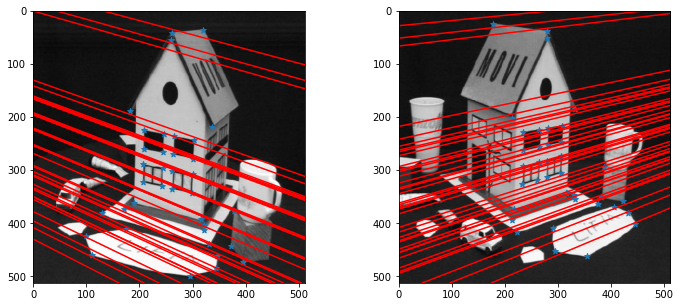

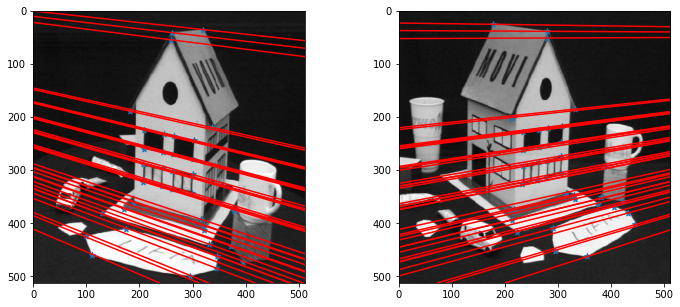

In [13]:
# Dataset1 plot
# read image files
img1 = skio.imread(im_set+'/image1.jpg')
img2 = skio.imread(im_set+'/image2.jpg')
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
# standard 8-point algorithm
F = lls_8points_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F)
# normalize 8-point algorithm
F_n = normalized_eight_point_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F_n)

d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F)
print('For Fundamental matrix obtained by 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2, '\n')
d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F_n)
print('For Fundamental matrix obtained by normalized 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2)

Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:
Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:
For Fundamental matrix obtained by 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 9.701438829422596
Average distance between points in image 2 to its corresponding epipolar line is 14.56822719047687 

For Fundamental matrix obtained by normalized 8-points Algorithm:
Average distance between points in image 1 to its corresponding epipolar line is 0.8895134540568618
Average distance between points in image 2 to its corresponding epipolar line is 0.8917343723800072


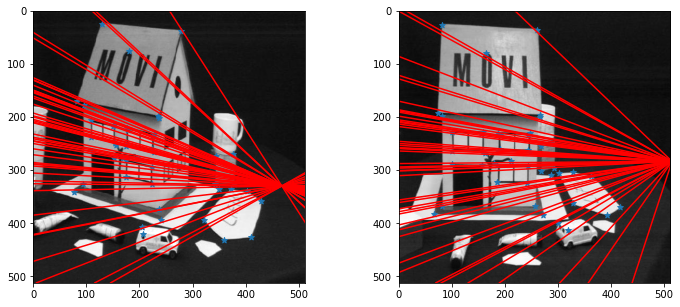

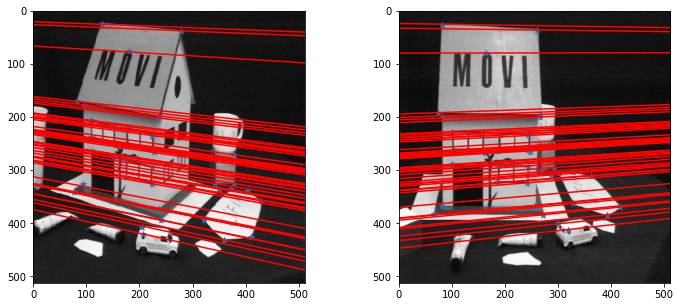

In [14]:
# Dataset2 plot
# read image files
img1 = skio.imread(im_set1+'/image1.jpg', as_gray=True)
img2 = skio.imread(im_set1+'/image2.jpg', as_gray=True)
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set1+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set1+'/pt_2D_2.txt')
# standard 8-point algorithm
F = lls_8points_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F)
# normalize 8-point algorithm
F_n = normalized_eight_point_fundamental(points1,points2)
# make the plot
print('Epipolar Lines from normalized 8-point algorithm estimated Fundamental Matrix:')
plot_epipolar_lines_on_images_mine(points1,points2,img1,img2,F_n)

d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F)
print('For Fundamental matrix obtained by 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2, '\n')
d1,d2 = compute_distance_to_epipolar_lines(points1,points2,F_n)
print('For Fundamental matrix obtained by normalized 8-points Algorithm:')
print('Average distance between points in image 1 to its corresponding epipolar line is',d1)
print('Average distance between points in image 2 to its corresponding epipolar line is',d2)

#### (d) Compute average distance from points to their corresponding Epipolar lines

In [15]:
def compute_distance_to_epipolar_lines(points1, points2, F):
    # get corresponding lines on each 'other' image
    lines1 = (F @ points2.T).T
    lines2 = (F.T @ points1.T).T
    # compute the distance
    dist1 = abs(np.sum(lines1*points1,axis=1)) / np.sqrt(lines1[:,0]**2 + lines1[:,1]**2)
    dist2 = abs(np.sum(lines2*points2,axis=1)) / np.sqrt(lines2[:,0]**2 + lines2[:,1]**2)
    # avg distance 
    avg_dist1 = np.mean(dist1)
    avg_dist2 = np.mean(dist2)
    return avg_dist1, avg_dist2

### 2. Matching Homographies for Image Rectification

#### (a). compute epipolar points $e_{1}, e_{2} \in \mathbb{P}^{2}$

In [16]:
# epipole is the intersection of all epipolar lines in an image 
def compute_epipole(points1,points2,F):
    # get corresponding epipolar lines
    L1 = (F @ points2.T).T
    L2 = (F.T @ points1.T).T
    # L @ e = 0 / L' @ e' = 0 use SVD to solve minimization problem with noise
    u,sig,vt = np.linalg.svd(L1)
    e1 = vt[-1]
    u,sig,vt = np.linalg.svd(L2)
    e2 = vt[-1]
    return e1/e1[2],e2/e2[2]

#### (b). Determine Matching Homographies $H_{1}$ and $H_{2}$
1. Error in the note: $F^T$ is treated as $F$, in the homographies algorithm section.
2. Error in the note: $[e']_{x}$ is writted as $[e]_{x}$

In [17]:
def compute_matching_homographies(e2, F, img2, points1, points2):
    # Compute H2 
    height,width = img2.shape
    # construct T
    T = np.array([[1,0, -width/2],
                  [0,1,-height/2],
                  [0,0,       1.]])
    # construct R
    tmp = T@e2
    cos,sin = tmp[:2] / np.sqrt(np.sum(tmp[:2]**2))
    R = int(cos>=0) * np.array([[cos, sin, 0.],
                                [-sin,cos, 0.],
                                [0.,   0., 1.]])
    # construct G
    f = (R@tmp)[0]
    G = np.array([[1.,  0.,0.],
                  [0.,  1.,0.],
                  [-1/f,0.,1.]])
    # H2 = T^{-1} @ G @ R @ T
    H2 = np.linalg.inv(T) @ G @ R @ T
    "Here is a Major difference: Note put [e1]_{x}@F while we should use [e2]_{x}@ F.T"
    ## e2 version: this is adopted with code ##
    # compute M
    ex = np.cross(e2, np.identity(e2.shape[0]) * -1)
    #M = ex @ F
    M = ex @ F.T + e2.reshape(-1,1) @ np.ones((1,3))

    # compute p1_hat and p2_hat
    p1_hat = (H2 @ M @ points1.T).T
    p1_hat = p1_hat / p1_hat[:,2:]
    p2_hat = (H2 @ points2.T).T
    p2_hat = p2_hat / p2_hat[:,2:]
    # construct W and b for the LS minimization problem for solving H_{A}
    W = p1_hat
    b = p2_hat[:,:1]
    # Solve linear least square min||Wx-b|| for a=(a_1,a_2,a_3)
    a = np.ravel(np.linalg.inv(W.T @ W) @ W.T @ b)
    # construct H_{A}
    HA = np.array([[a[0], a[1], a[2]],
                   [0.,     1.,   0.],
                   [0.,     0.,   1.]])
    # compute H1 = H_A @ H2 @ M
    H1 = HA @ H2 @ M
    return H1,H2

#### (c). Rectify image and plot it

Above procedure uses an extra function (pre-built), which we explain here:

Retified Image satisfies:
$$
Img_{rec}(x,y) = Img( H^{-1} [x + o_x,y + o_y,1]^{T} )
$$
Where we note that the image formation in python is Img(y,x) instead of Img(x,y). The offset ensures that the rectified image has a minimum value of $0$.

In [18]:
"Detailed Explaination of what this function is doing"
def compute_rectified_image(im, H):
    new_x = np.zeros(im.shape[:2])
    new_y = np.zeros(im.shape[:2])
    "Applies Homography to image and Im_new(H @ (x,y,1).T)= Im_old(x,y)"
    "Subtract offset such that new_x/y has minimum value of 0"
    "Record the new dimensionality of the new image"
    "Offset works as such: Im_new(x,y) = Im_old(H_inv @ (x+offset_x,y+offset_y,1).T)"
    "Where latter term exists, otherwise Im_new(x,y)=0"
    for y in range(im.shape[0]): # height
        for x in range(im.shape[1]): # width
            new_location = H.dot([x, y, 1])
            new_location /= new_location[2]
            new_x[y,x] = new_location[0]
            new_y[y,x] = new_location[1]
    offsets = (new_x.min(), new_y.min())
    new_x -= offsets[0]
    new_y -= offsets[1]
    new_dims = (int(np.ceil(new_y.max()))+1,int(np.ceil(new_x.max()))+1)

    H_inv = np.linalg.inv(H)
    new_image = np.zeros(new_dims)
    "this is for the completeness of the new image, fill all its dimensionality"
    "as long as it HAS a cooresponding position in the old image"
    "If it does not, we leave it blank (white color pixel for this position)"
    for y in range(new_dims[0]):
        for x in range(new_dims[1]):
            old_location = H_inv.dot([x+offsets[0], y+offsets[1], 1])
            old_location /= old_location[2]
            old_x = int(old_location[0])
            old_y = int(old_location[1])
            if old_x >= 0 and old_x < im.shape[1] and old_y >= 0 and old_y < im.shape[0]:
                new_image[y,x] = im[old_y, old_x]

    return new_image, offsets

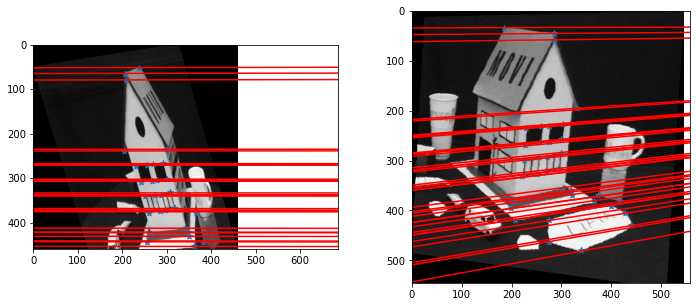

In [19]:
# Dataset1 plot
# read image files
img1 = skio.imread(im_set+'/image1.jpg')
img2 = skio.imread(im_set+'/image2.jpg')
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
# Fundamental Matrix estimation with normalized 8-points algorithm
F = normalized_eight_point_fundamental(points1,points2)
# Compute Epipoles
e1,e2 = compute_epipole(points1,points2,F_n)
# Compute Homographies
H1,H2 = compute_matching_homographies(e2,F,img2,points1,points2)
# Transforming the images by the homographies, cut by offset 
new_p1 = (H1 @ (points1.T)).T
new_p1 /= new_p1[:,2:]
new_p2 = (H2 @ (points2.T)).T
new_p2 /= new_p2[:,2:]
rectified_im1, offset1 = compute_rectified_image(img1, H1)
rectified_im2, offset2 = compute_rectified_image(img2, H2)
new_p1 -= offset1 + (0,)
new_p2 -= offset2 + (0,)
# Plotting the image
F_new = normalized_eight_point_fundamental(new_p1, new_p2)
plot_epipolar_lines_on_images_mine(new_p1, new_p2, rectified_im1, rectified_im2, F_new)

### 3. The Factorization Method (affine structure from motion)
#### (a) facatorization method

In [20]:
def factorization_method(points1,points2):
    # factorization method
    centeroid1 = np.mean(points1,axis=0)[:2]
    centeroid2 = np.mean(points2,axis=0)[:2]
    # translated points
    pts1 = points1[:,:2] - centeroid1
    pts2= points2[:,:2]- centeroid2
    # measurement matrix
    D = np.concatenate((pts1.T,pts2.T),axis=0) 
    # Singular Value Decomposition
    u,sig,vt = np.linalg.svd(D)
    print('Singular Values found:',sig)
    # best rank-3 approximation
    u3 = u[:,:3]
    vt3 = vt[:3,:]
    sig3 = np.diag(sig[:3])
    # Structure & Motion matrix (robust choice)
    M = u3 @ np.sqrt(sig3)
    S = np.sqrt(sig3) @ vt3
    return M,S

def scatter_3D_axis_equal(X, Y, Z, ax):
    ax.scatter(X, Y, Z)
    max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

    mid_x = (X.max()+X.min()) * 0.5
    mid_y = (Y.max()+Y.min()) * 0.5
    mid_z = (Z.max()+Z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

#### (b). plot comparing factorization sturcutre to ground truth: ambiguity of structure upto scaling, rotation and translaition

#### (c). report singular values

Singular Values found: [959.5852216  540.47613178 184.43174791  27.9151956 ]


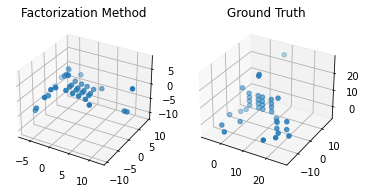

In [21]:
# read image files
img1 = skio.imread(im_set+'/image1.jpg')
img2 = skio.imread(im_set+'/image2.jpg')
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
# read the ground truth 3d points in world coordinate
points_3d = get_data_from_txt_file(im_set + '/pt_3D.txt')
# factorization method
motion, structure = factorization_method(points1,points2)
# the affine structure from motion provides 'cenetered structure in 3D'
# Plot the structure
fig = plt.figure()
ax = fig.add_subplot(121, projection = '3d')
scatter_3D_axis_equal(structure[0,:], structure[1,:], structure[2,:], ax)
ax.set_title('Factorization Method')
ax = fig.add_subplot(122, projection = '3d')
scatter_3D_axis_equal(points_3d[:,0], points_3d[:,1], points_3d[:,2], ax)
ax.set_title('Ground Truth')

plt.show()

#### (d). Factorization on a subset of points

We have 18 points here, since for affine structure from motion problem, we have $2mn$ equations to solve for $8m+3n$ unknowns ($n$ is the number of corresponding points, $m$ is the number of cameras) we known that ideally one need at least $n=16$ when $m=2$ (Note that due to $rank(D)\leq 3$, we should need more points than $16$.

#### (e). report singular values and explain

In this case, we almost have a $rank(D)=2$, this means the linear systems with $2nm$ equations has less linear independent components, and thus in practice fail to solve for the structure & motions matrix with only $n=18$ corresponding points.

Singular Values found: [264.54396508 210.06072009   7.21921783   5.12857709]


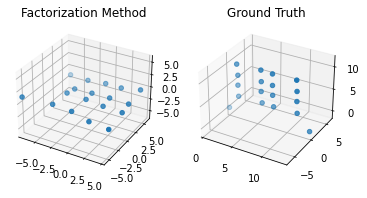

In [22]:
# read image files
img1 = skio.imread(im_subset+'/image1.jpg')
img2 = skio.imread(im_subset+'/image2.jpg')
# read the txt file for the homogeneous 2D coordinates in both images: we have 37 pairs
points1 = get_data_from_txt_file(im_subset+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_subset+'/pt_2D_2.txt')
# read the ground truth 3d points in world coordinate
points_3d = get_data_from_txt_file(im_subset + '/pt_3D.txt')
# factorization method
motion, structure = factorization_method(points1,points2)
# the affine structure from motion provides 'cenetered structure in 3D'
# Plot the structure
fig = plt.figure()
ax = fig.add_subplot(121, projection = '3d')
scatter_3D_axis_equal(structure[0,:], structure[1,:], structure[2,:], ax)
ax.set_title('Factorization Method')
ax = fig.add_subplot(122, projection = '3d')
scatter_3D_axis_equal(points_3d[:,0], points_3d[:,1], points_3d[:,2], ax)
ax.set_title('Ground Truth')

plt.show()

### 4. Triangulation in Structure from Motion (projective transformation camera)

In [23]:
import os

# Load the data
image_data_dir = 'data/statue/'
unit_test_camera_matrix = np.load('data/unit_test_camera_matrix.npy')
unit_test_image_matches = np.load('data/unit_test_image_matches.npy')
image_paths = [os.path.join(image_data_dir, 'images', x) for x in
    sorted(os.listdir('data/statue/images')) if '.jpg' in x]
focal_length = 719.5459

matches_subset = np.load(os.path.join(image_data_dir,'matches_subset.npy'), allow_pickle=True, encoding = 'latin1')[0,:]
dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'), allow_pickle=True, encoding = 'latin1')
fundamental_matrices = np.load(os.path.join(image_data_dir,'fundamental_matrices.npy'), allow_pickle=True, encoding = 'latin1')[0,:]

#### (a). Estimate Initial $R,T$

In [24]:
'''
ESTIMATE_INITIAL_RT from the Essential Matrix, we can compute 4 initial
guesses of the relative RT between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
Returns:
    RT: A 4x3x4 tensor in which the 3x4 matrix RT[i,:,:] is one of the
        four possible transformations
'''
def estimate_initial_RT(E):
    
    u,sig,vt = np.linalg.svd(E)
    #U = u * np.mean(sig[:2])
    U = u
    VT = vt
    Z = np.zeros((3,3))
    W = np.zeros((3,3))
    Z[0,1],Z[1,0] = 1,-1
    W[0,1],W[1,0],W[2,2]=-1,1,1
    #M = U@Z@U.T
    Q1 = U@W@VT
    Q2 = U@W.T@VT
    R1 = np.linalg.det(Q1) * Q1
    R2 = np.linalg.det(Q2) * Q2
    T1 = U[:,2]
    T2 = -U[:,2]
    RTs = np.zeros((4,3,4))
    RTs[0] = np.hstack((R1,np.reshape(T1,(-1,1))))
    RTs[1] = np.hstack((R1,np.reshape(T2,(-1,1))))
    RTs[2] = np.hstack((R2,np.reshape(T1,(-1,1))))
    RTs[3] = np.hstack((R2,np.reshape(T2,(-1,1))))
    return RTs

In [25]:
# Part A: Computing the 4 initial R,T transformations from Essential Matrix

K = np.eye(3)
K[0,0] = K[1,1] = focal_length
E = K.T.dot(fundamental_matrices[0]).dot(K)
example_RT = np.array([[0.9736, -0.0988, -0.2056, 0.9994],
                        [0.1019, 0.9948, 0.0045, -0.0089],
                        [0.2041, -0.0254, 0.9786, 0.0331]])
RTs = estimate_initial_RT(E)

print('Example RT is:\n', example_RT)
print('Estimated RT is:\n', RTs)

Example RT is:
 [[ 0.9736 -0.0988 -0.2056  0.9994]
 [ 0.1019  0.9948  0.0045 -0.0089]
 [ 0.2041 -0.0254  0.9786  0.0331]]
Estimated RT is:
 [[[ 0.98305251 -0.11787055 -0.14040758  0.99941228]
  [-0.11925737 -0.99286228 -0.00147453 -0.00886961]
  [-0.13923158  0.01819418 -0.99009269  0.03311219]]

 [[ 0.98305251 -0.11787055 -0.14040758 -0.99941228]
  [-0.11925737 -0.99286228 -0.00147453  0.00886961]
  [-0.13923158  0.01819418 -0.99009269 -0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
  [ 0.10189204  0.99478508  0.00454512 -0.00886961]
  [ 0.2040601  -0.02537241  0.97862951  0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119 -0.99941228]
  [ 0.10189204  0.99478508  0.00454512  0.00886961]
  [ 0.2040601  -0.02537241  0.97862951 -0.03311219]]]


#### (b) linear estimate of 3D points

In [26]:
'''
LINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point is the best linear estimate
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point
'''
def linear_estimate_3d_point(image_points, camera_matrices):
    # construction of matrix A
    A1 = image_points[:,:1] * camera_matrices[:,2] - camera_matrices[:,0]
    A2 = image_points[:,1:] * camera_matrices[:,2] - camera_matrices[:,1]
    A = np.vstack((A1,A2))
    # svd to solve contraint minimizor P
    u,sig,vt = np.linalg.svd(A)
    P = vt[-1]
    P = P / P[-1]
    return P

In [27]:
# Part B: Determining the best linear estimate of a 3D point
camera_matrices = np.zeros((2, 3, 4))
camera_matrices[0, :, :] = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
camera_matrices[1, :, :] = K.dot(example_RT)
# corresponding points in image to world coordinate object points
unit_test_matches = matches_subset[0][:,0].reshape(2,2)
# expected 3D position
expected_3d_point = np.array([0.6774, -1.1029, 4.6621])
# estimate 3D point
estimated_3d_point = linear_estimate_3d_point(unit_test_matches.copy(), camera_matrices.copy())
print('Estimated 3d point:\n',estimated_3d_point[:3])
print('Expected 3d point:\n',expected_3d_point)
print('Euclidean Distance between estimated and expected 3d points is:',np.linalg.norm(estimated_3d_point[:3] - expected_3d_point))

Estimated 3d point:
 [ 0.67671686 -1.10241883  4.66034   ]
Expected 3d point:
 [ 0.6774 -1.1029  4.6621]
Euclidean Distance between estimated and expected 3d points is: 0.0019482813049785778


#### (c). Reprojection Error and Jacobian matrix (wrt to $P$)

In [28]:
'''
REPROJECTION_ERROR given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    error - the 2Mx1 reprojection error vector (shape of (2M,) in fact)
'''
def reprojection_error(point_3d, image_points, camera_matrices):
    # convert to homogeneous 3d coordinate
    if point_3d.shape[0]==3:
        point_3d = np.pad(point_3d,(0,1),constant_values=1)
    # projected 2d point in homogeneous coordinate
    homo_2d = camera_matrices @ point_3d
    # converge to 2d non-homogeneous coordinate
    point_2d = homo_2d[:,:2] / homo_2d[:,2:]
    # compute error
    error = point_2d - image_points
    return error.reshape(-1)

In [29]:
'''
JACOBIAN given a 3D point and its corresponding points in the image
planes, compute the reprojection error vector and associated Jacobian
Arguments:
    point_3d - the 3D point corresponding to points in the image
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    jacobian - the 2Mx3 Jacobian matrix
'''
def jacobian(point_3d, camera_matrices):
    # number of cameras
    m = camera_matrices.shape[0]
    # convert to homogeneous 3d coordinate
    if point_3d.shape[0]==3:
        point_3d = np.pad(point_3d,(0,1),constant_values=1)
    # projected 2d point in homogeneous coordinate
    homo_2d = camera_matrices @ point_3d
    # vectorized version of Jacobian computation
    j1 = (camera_matrices[:,0,:3]*homo_2d[:,2:] - camera_matrices[:,2,:3]*homo_2d[:,:1]) / (homo_2d[:,2:]**2)
    j2 = (camera_matrices[:,1,:3]*homo_2d[:,2:] - camera_matrices[:,2,:3]*homo_2d[:,1:2]) / (homo_2d[:,2:]**2)
    J = np.ones((2*m,3))
    J[::2] = j1
    J[1::2] = j2
    return J

In [30]:
estimated_error = reprojection_error(expected_3d_point, unit_test_matches, camera_matrices)
estimated_jacobian = jacobian(expected_3d_point, camera_matrices)
expected_error = np.array((-0.0095458, -0.5171407,  0.0059307,  0.501631))
print("Error Difference: ", np.fabs(estimated_error - expected_error).sum())
expected_jacobian = np.array([[ 154.33943931, 0., -22.42541691],
     [0., 154.33943931, 36.51165089],
     [141.87950588, -14.27738422, -56.20341644],
     [21.9792766, 149.50628901, 32.23425643]])
print("Jacobian Difference: ", np.fabs(estimated_jacobian - expected_jacobian).sum())

Error Difference:  8.301300130674275e-07
Jacobian Difference:  1.817115702351657e-08


#### (d). Gauss-Newton method for non-lnear optimization to solve $\hat{P}$

In [31]:
'''
NONLINEAR_ESTIMATE_3D_POINT given a corresponding points in different images,
compute the 3D point that iteratively updates the points
Arguments:
    image_points - the measured points in each of the M images (Mx2 matrix)
    camera_matrices - the camera projective matrices (Mx3x4 tensor)
Returns:
    point_3d - the 3D point ((3,) vector)
'''
def nonlinear_estimate_3d_point(image_points, camera_matrices):
    # Linear estimate of 3d point as initial position
    P = linear_estimate_3d_point(image_points, camera_matrices)[:3]
    iterations = 10
    # Gauss-Newton optimization
    for i in range(iterations):
        e = reprojection_error(P, image_points, camera_matrices)
        J = jacobian(P, camera_matrices)
        P -= np.linalg.inv(J.T @ J) @ J.T @ e
    return P

In [32]:
estimated_3d_point_linear = linear_estimate_3d_point(unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
estimated_3d_point_nonlinear = nonlinear_estimate_3d_point(unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
error_linear = reprojection_error(estimated_3d_point_linear, unit_test_image_matches, unit_test_camera_matrix)
print("Linear method error:", np.linalg.norm(error_linear))
error_nonlinear = reprojection_error(estimated_3d_point_nonlinear, unit_test_image_matches, unit_test_camera_matrix)
print("Nonlinear method error:", np.linalg.norm(error_nonlinear))

Linear method error: 98.73542356894181
Nonlinear method error: 95.59481784846032


#### (e). Determining the correct R, T from Essential Matrix

we deal with two cameras system
$M_{1} = K [I_{3\times 3}\,\,\,0_{3\times 1}]$, $M_{2} = K [R^{T}\,\,\,-R^{T}T]$

In [35]:
'''
ESTIMATE_RT_FROM_E from the Essential Matrix, we can compute  the relative RT 
between the two cameras
Arguments:
    E - the Essential Matrix between the two cameras
    image_points - N measured points in each of the M images (NxMx2 matrix)
    K - the intrinsic camera matrix
Returns:
    RT: The 3x4 matrix which gives the rotation and translation between the 
        two cameras
'''

def estimate_RT_from_E(E, image_points, K):
    # record number of points and number of cameras
    n,m = image_points.shape[:2]
    # obtain 4 possible R & T from Essential Matrix E
    RTs = estimate_initial_RT(E)
    # index of choice
    i_argmax = 0
    max_count = 0
    IO = np.pad(np.eye(3), ((0,0),(0,1)), constant_values=0)
    # deal with 4 combinations seperately
    for i in range(4):
        # obtain camera matrices from K & R & T combinations, shape (M,3,4)
        M1 = K @ IO
        R = RTs[i][:,:3]
        T = RTs[i][:,3]
        E2 = np.hstack((R.T, (-R.T@T).reshape(-1,1)))
        M2 = K @ E2
        camera_matrices = np.stack((M1,M2),axis=0)
        # record count
        count = 0
        for j in range(n):
            # nonlinear-estimate of 3d point shape (N,3)
            estimated_3d_point = nonlinear_estimate_3d_point(image_points[j], camera_matrices)
            # Projection onto 1st & 2nd camera coordinates
            c1 = estimated_3d_point
            c2 = E2@np.hstack((estimated_3d_point,1))
            # count the number of positive z-axis value for each R & T combinations
            count += int(c1[-1]>0) + int(c2[-1]>0)
        # update on the maximum count & argmax index values recursively
        if count>=max_count:
            i_argmax = i
            max_count = count
    return RTs[i_argmax]

In [36]:
estimated_RT = estimate_RT_from_E(E, np.expand_dims(unit_test_image_matches[:2,:], axis=0), K)
print('Estimated RT:\n', estimated_RT)
print('Expected RT:\n', example_RT)

Estimated RT:
 [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
 [ 0.10189204  0.99478508  0.00454512 -0.00886961]
 [ 0.2040601  -0.02537241  0.97862951  0.03311219]]
Expected RT:
 [[ 0.9736 -0.0988 -0.2056  0.9994]
 [ 0.1019  0.9948  0.0045 -0.0089]
 [ 0.2041 -0.0254  0.9786  0.0331]]


#### (f). Run the entire Structure From Motion (SFM) pipeline

In [112]:
# A class that stores information about multiple views of the scene
"""
This class concerns information of matching views (two view system)
N: number of matching points pairs 
matches: (N, 4)

"""
class Frame:
    def __init__(self, matches, focal_length, F, im_width, im_height):
        self.focal_length = focal_length
        self.im_height = im_height
        self.im_width = im_width
        self.matches = matches
        # number of matching picture pairs
        self.N = matches.shape[0]
        # probably used to index on points in two pictures shape: (2,N)
        self.match_idx = np.arange(2*self.N).reshape(2,-1)
        # seperate points in two images: shape (2*N,2)
        self.match_points = np.vstack((matches[:,:2], matches[:,2:]))
        # with intrinsic matrix K assumption, compute E from F (fundamental matrix)
        self.K = np.eye(3)
        self.K[0,0] = self.K[1,1] = focal_length
        self.E = self.K.T.dot(F).dot(self.K)
        
        self.T = estimate_RT_from_E(self.E, matches.reshape((-1,2,2)), self.K)
        # so-called motion here contain 2 extrinsic matrix for two cameras
        # first one treated as [I,0], the other one [R,T]
        self.motion = np.zeros((2,3,4))
        self.motion[0,:,:-1] = np.eye(3)
        self.motion[1,:,:] = self.T
        # so-called structure should just be the 3d points triangulated
        self.structure = triangulate(self)

#### Missing funciton: Triangulate

In [113]:
'''
TRIANGULATE
Arguments:
    frame - information about multiple views of the scene
Returns:
    structure - the 3D points of the scene
'''
def triangulate(frame):
    # it tries to generalize to multiple views, i m dubious
    num_cameras, num_points = frame.match_idx.shape
    structure = np.zeros((num_points,3))
    all_camera_matrices = np.zeros((num_cameras, 3, 4))
    # M = K @ [R T]
    all_camera_matrices = frame.K @ frame.motion
    # It assume some negative values can exist in match_idx and extract 
    # only positive match_idx to perform triangulation
    for i in range(num_points):
        # unless future maneuver fit neagatice value on match_idx, this 
        # simply reads: valid_cameras = np.array([0, 1])
        valid_cameras = np.where(frame.match_idx[:,i] >= 0)[0]
        # then this simply gives back all_camera_matrices
        camera_matrices = all_camera_matrices[valid_cameras,:,:]
        x = np.zeros((len(valid_cameras), 2))
        for ctr, c in enumerate(valid_cameras):
            # in the simple case: ctr=c \in {0,1}
            x[ctr, :] = frame.match_points[frame.match_idx[c, i],:]
        structure[i,:] = nonlinear_estimate_3d_point(x, camera_matrices)

    return structure 

In [119]:
from sfm_utils import *

In [120]:
"""
1. There are 5 pictures of the statue so why we only define 4 frames?
2. Only 4 fundamental matrices are provided (for a pair of pics we have 1 Fundamental matrix)
3. The 4 set of 'matches_subset' represent for each of the 4 pairs, image points (2D)
   matches which forms a (4, # of matches) array, where first 2 rows are for one pic
   and the last 2 rows are for the other pic
4. 
"""
im0 = skio.imread(image_paths[0])

im_height, im_width, _ = im0.shape
frames = [0] * (len(image_paths) - 1)
for i in range(len(image_paths)-1):
    frames[i] = Frame(matches_subset[i].T, focal_length,
            fundamental_matrices[i], im_width, im_height)
    bundle_adjustment(frames[i])
merged_frame = merge_all_frames(frames)

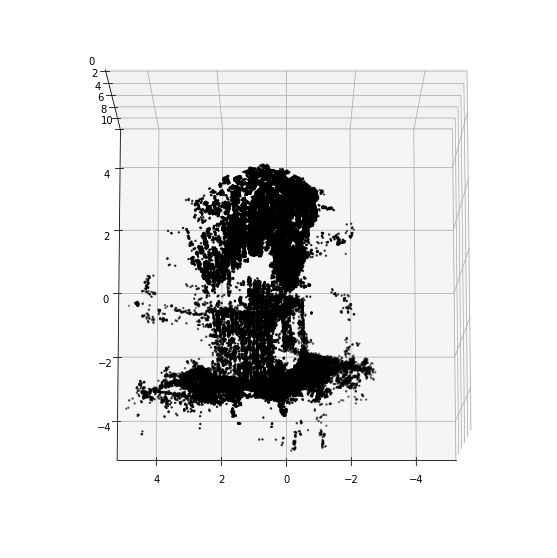

In [123]:
# Construct the dense matching
camera_matrices = np.zeros((2,3,4))
dense_structure = np.zeros((0,3))
for i in range(len(frames)-1):
    matches = dense_matches[i]
    camera_matrices[0,:,:] = merged_frame.K.dot(
        merged_frame.motion[i,:,:])
    camera_matrices[1,:,:] = merged_frame.K.dot(
            merged_frame.motion[i+1,:,:])
    points_3d = np.zeros((matches.shape[1], 3))
    use_point = np.array([True]*matches.shape[1])
    for j in range(matches.shape[1]):
        points_3d[j,:] = nonlinear_estimate_3d_point(
            matches[:,j].reshape((2,2)), camera_matrices)
    dense_structure = np.vstack((dense_structure, points_3d[use_point,:]))

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.scatter(dense_structure[:,0], dense_structure[:,1], dense_structure[:,2],
    c='k', depthshade=True, s=2)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(0, 10)
ax.view_init(-100, 90)

plt.show()